# Modelling and HyperParameter tuning

In this notebook, the modeling phase is achieved. Three different models: decision trees, random forest and logistic regression are used. The models are also compared with the augmented dataset vs the non-augmented dataset. The hyper parameter tuning is achieved using cross-validation.

## Import Packages and Read Data 

In [1]:
# Import the neccessary packages
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, SQLTransformer,IndexToString
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd

from sklearn.metrics import confusion_matrix

import numpy as np

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

In [2]:
# Start Spark Session with Spark NLP
spark = sparknlp.start()

In [3]:
# Read dataframes as spark dataframes

# Non-augmented training set
sparkDf = spark.read.option("header",True).csv("../Data/cleanedpandasDf.csv")

# Test set
sparkTestDf = spark.read.option("header",True).csv("../Data/cleanedpandastestDf.csv")

# Augmented training set
sparkAugDf = spark.read.option("header",True).csv("../Data/cleanedAugmentedPandasDf.csv")

## Generating Embeddings

In [4]:
def generateEmbeddings(df, columnName):
    """
    This function builds a pipeline and generates the tf-idf embeddings for a given data frame and a chosen textual column (title/description/text)
    and returns the dataframe with embeddings.
    """
    document_assembler = DocumentAssembler() \
        .setInputCol(columnName) \
        .setOutputCol("document")

    # convert document to array of tokens
    tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")

    #check spellings
    spell_model = ContextSpellCheckerModel\
        .pretrained('spellcheck_dl')\
        .setInputCols("token")\
        .setOutputCol("corrected")

    # clean tokens 
    normalizer = Normalizer() \
        .setInputCols(["corrected"]) \
        .setOutputCol("normalized")

    # remove stopwords
    stopwords_cleaner = StopWordsCleaner()\
          .setInputCols("normalized")\
          .setOutputCol("cleanTokens")\
          .setCaseSensitive(False)

    # lemmas tokens to bring it to root form
    lemmatizer = LemmatizerModel.pretrained() \
        .setInputCols(["token"]) \
        .setOutputCol("lemma")

    # Convert custom document structure to array of tokens.
    finisher = Finisher() \
        .setInputCols(["lemma"]) \
        .setOutputCols(["token_features"]) \
        .setOutputAsArray(True) \
        .setCleanAnnotations(False)

    # To generate Term Frequency
    hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=1000)

    # To generate Inverse Document Frequency
    idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

    # convert labels (string) to integers. Easy to process compared to string.
    label_stringIdx = StringIndexer(inputCol = "level", outputCol = "label")

    # define the nlp pipeline
    nlp_pipeline = Pipeline(
        stages=[document_assembler, 
                tokenizer,
                spell_model,
                normalizer,
                stopwords_cleaner, 
                lemmatizer, 
                finisher,
                hashingTF,
                idf,
                label_stringIdx])

    # fit the pipeline 
    pipeline_model = nlp_pipeline.fit(df)
    # generate embeddings
    embeddings =  pipeline_model.transform(df)

    return embeddings

#### Generate embeddings for non-augmented dataset 

In [5]:
# Generating embeddings for the "title" column
title_embeddings = generateEmbeddings(sparkDf, "title")

# Generating embeddings for the "description" column
description_embeddings = generateEmbeddings(sparkDf, "description")

# Generating embeddings for the "text" column
text_embeddings = generateEmbeddings(sparkDf, "text")

spellcheck_dl download started this may take some time.
Approximate size to download 111.4 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
spellcheck_dl download started this may take some time.
Approximate size to download 111.4 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
spellcheck_dl download started this may take some time.
Approximate size to download 111.4 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#### Generate embeddings for the augmented dataset 

In [6]:
# Generating embeddings for the "text" column
augEmbeddings = generateEmbeddings(sparkAugDf, "text")

spellcheck_dl download started this may take some time.
Approximate size to download 111.4 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [8]:
augEmbeddings.select('level','label').distinct().show()

+-----+-----+
|level|label|
+-----+-----+
|    2|  1.0|
|    0|  2.0|
|    1|  3.0|
|    3|  0.0|
+-----+-----+



## Train-test split 

In [9]:
def trainTestSplit(df):
    """
    Split dataframe into train and test sets by stratified sampling.
    
    """
    # Create test set by stratified sampling (15% of each class)
    test = df.sampleBy("label", fractions={0.0: 0.15,
                                           1.0: 0.15,
                                           2.0: 0.15,
                                           3.0: 0.15},
                       seed=100)
    
    # Remove test set entries from original dataframe to create train set
    train = df.join(test, on='_c0', how='left_anti')
    
    return train, test

### title_embeddings 

In [10]:
 # Split the dataframe into train and test
title_train, title_test = trainTestSplit(title_embeddings)

### description_embeddings 

In [11]:
 # Split the dataframe into train and test
description_train, description_test = trainTestSplit(description_embeddings)

### text_embeddings 

In [12]:
 # Split the dataframe into train and test
text_train, text_test = trainTestSplit(text_embeddings)

### augmented_embeddings 

In [13]:
 # Split the dataframe into train and test
aug_train, aug_test = trainTestSplit(augEmbeddings)

## Modelling 

In [14]:
def metricsEvaluation(prediction):
    """
    This function calculates the confusion matrix, the accuracy, precision, recall scores for the given prediction.
    """    
    
     #accuracy
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(prediction)
    print("Accuracy = %g" % (accuracy))

    #precision
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    precision = evaluator.evaluate(prediction)
    print("Precision = %g" % (precision))

    #recall
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    recall = evaluator.evaluate(prediction)
    print("Recall = %g" % (recall))
    
    #recall
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")
    f1score = evaluator.evaluate(prediction)
    print("F1_score = %g" % (f1score))
    
    #confusion matrix
    df = prediction.select("label", "prediction").toPandas()
    confusionMatrix = confusion_matrix(df["label"], df["prediction"])
    print("\nCONFUSION MATRIX\n")
    print(confusionMatrix)
    
    
    return accuracy, precision, recall, confusionMatrix
    

### Decision Tree 

In [13]:
def decisionTreeClassifierModel(train, test):
    """
    This function builds the decision tree classifier model and returns the evaluation scores.
    """
    
    # Create initial Decision Tree Model
    model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
    
    # fit the model on the training set
    dt = model.fit(train)
    
    # Transform the test set to get the prediction
    prediction = dt.transform(test)
    
    return metricsEvaluation(prediction)

#### Non-augmented Dataset 

map: {0: senior-level, 1: mid-level, 2: Entry-level, 3: internships}

In [14]:
# checking for the title embeddings
print("Title\n")
accuracyTtl_dt, precisionTtl_dt, recallTtl_dt, confusionMatrixTtl_dt = decisionTreeClassifierModel(title_train, title_test)

Title

Accuracy = 0.55
Precision = 0.589286
Recall = 0.55
F1_score = 0.506124

CONFUSION MATRIX

[[4 0 3 0]
 [0 0 5 0]
 [0 0 5 0]
 [0 0 1 2]]


In [15]:
# checking for the description embeddings
print("Description\n")
accuracyDscp_dt, precisionDscp_dt, recallDscp_dt, confusionMatrixDscp_dt = decisionTreeClassifierModel(description_train, description_test)

Description

Accuracy = 0.25
Precision = 0.2
Recall = 0.25
F1_score = 0.209868

CONFUSION MATRIX

[[4 1 0 2]
 [3 0 1 1]
 [3 1 1 0]
 [2 0 1 0]]


In [16]:
# checking for the text embeddings
print("Text(title + description)\n")
accuracyTxt_dt, precisionTxt, recallTxt_dt, confusionMatrixTxt_dt = decisionTreeClassifierModel(text_train, text_test)

Text(title + description)

Accuracy = 0.55
Precision = 0.627083
Recall = 0.55
F1_score = 0.555769

CONFUSION MATRIX

[[4 1 2 0]
 [0 3 2 0]
 [1 1 3 0]
 [1 0 1 1]]


#### Augmented dataset 

In [17]:
print("Augmented Text(title + description)\n")
accuracyaug_dt, precisionaug_dt, recallaug_dt, confusionMatrixaug_dt = decisionTreeClassifierModel(aug_train, aug_test)

Augmented Text(title + description)

Accuracy = 0.806452
Precision = 0.903226
Recall = 0.806452
F1_score = 0.821114

CONFUSION MATRIX

[[ 4  3  0  0]
 [ 0  6  0  0]
 [ 0  1  5  0]
 [ 0  2  0 10]]


### Random Forest Classifier

In [18]:
def rfClassifierModel(train, test):
    """
    This function builds the random forest classifier model and returns the evaluation scores.
    """
    # Create initial random forest Model
    model = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
    
    # Fit the training set
    rf = model.fit(train)
    
    # Transform the test set to get the predictions
    prediction = rf.transform(test)
    
    return metricsEvaluation(prediction)

#### Non-augmented Dataset 

In [19]:
# checking for the title embeddings
print("Title\n")
accuracyTtl_rf, precisionTtl_rf, recallTtl_rf, confusionMatrixTtl_dt = rfClassifierModel(title_train, title_test)

Title

Accuracy = 0.35
Precision = 0.1225
Recall = 0.35
F1_score = 0.181481

CONFUSION MATRIX

[[7 0 0 0]
 [5 0 0 0]
 [5 0 0 0]
 [3 0 0 0]]


In [20]:
# checking for the description embeddings
print("Description\n")
accuracyDscp_rf, precisionDscp_rf, recallDscp_rf, confusionMatrixDscp_dt = rfClassifierModel(description_train, text_test)

Description

Accuracy = 0.35
Precision = 0.458333
Recall = 0.35
F1_score = 0.342262

CONFUSION MATRIX

[[4 1 2 0]
 [4 1 0 0]
 [4 0 1 0]
 [2 0 0 1]]


In [21]:
# checking for the text embeddings
print("Text(title + description)\n")
accuracyTxt_rf, precisionTxt_rf, recallTxt_rf, confusionMatrixTxt_rf = rfClassifierModel(text_train, text_test)

Text(title + description)

Accuracy = 0.4
Precision = 0.485417
Recall = 0.4
F1_score = 0.393063

CONFUSION MATRIX

[[3 3 1 0]
 [2 3 0 0]
 [3 1 1 0]
 [1 1 0 1]]


#### Augmented dataset 

In [22]:
print("Augmented Text(title + description)\n")
accuracyaug_rf, precisionaug_rf, recallaug_rf, confusionMatrixaug_rf = rfClassifierModel(aug_train, aug_test)

Augmented Text(title + description)

Accuracy = 0.774194
Precision = 0.80783
Recall = 0.774194
F1_score = 0.772097

CONFUSION MATRIX

[[ 5  0  1  1]
 [ 2  3  0  1]
 [ 1  0  5  0]
 [ 1  0  0 11]]


###  Logistic Regression Classifier

In [15]:
def lrClassifierModel(train, test):
    """
    This function builds the gradient boost classifier model and returns the evaluation scores.
    """
    
    # Create logistic regression Model
    model = LogisticRegression(featuresCol = 'features', labelCol = 'label')
    
    # Fit the model on the train set
    lr = model.fit(train)
    
    # Transform the test set to get the predictions
    prediction = lr.transform(test)
    
    return metricsEvaluation(prediction)


#### Non-augmented Dataset 

In [24]:
#checking for the title embeddings
print("Title\n")
accuracyTtl_lr, precisionTtl_lr, recallTtl_lr, confusionMatrixTtl_lr = lrClassifierModel(title_train, title_test)


Title

Accuracy = 0.7
Precision = 0.711667
Recall = 0.7
F1_score = 0.683235

CONFUSION MATRIX

[[7 0 0 0]
 [1 2 2 0]
 [1 1 3 0]
 [1 0 0 2]]


In [25]:

#checking for the description embeddings
print("Description\n")
accuracyDscp_lr, precisionDscp_lr, recallDscp_lr, confusionMatrixDscp_lr = lrClassifierModel(description_train, description_test)


Description

Accuracy = 0.5
Precision = 0.472917
Recall = 0.5
F1_score = 0.471111

CONFUSION MATRIX

[[2 2 2 1]
 [0 5 0 0]
 [2 1 2 0]
 [2 0 0 1]]


In [26]:

#checking for the text embeddings
print("Text(title + description)\n")
accuracyTxt_lr, precisionTxt_lr, recallTxt_lr, confusionMatrixTxt_lr = lrClassifierModel(text_train, text_test)

Text(title + description)

Accuracy = 0.55
Precision = 0.629167
Recall = 0.55
F1_score = 0.499837

CONFUSION MATRIX

[[1 5 1 0]
 [0 5 0 0]
 [0 1 4 0]
 [1 1 0 1]]


#### Augmented dataset 

In [27]:
print("Augmented Text(title + description)\n")
accuracyaug_lr, precisionaug_lr, recallaug_lr, confusionMatrixaug_lr = lrClassifierModel(aug_train, aug_test)

Augmented Text(title + description)

Accuracy = 0.870968
Precision = 0.874194
Recall = 0.870968
F1_score = 0.864823

CONFUSION MATRIX

[[ 4  1  2  0]
 [ 1  5  0  0]
 [ 0  0  6  0]
 [ 0  0  0 12]]


### Metrics comparison 

In [76]:
def plotBarGraph(y1, y2, y3, y4, metricName):
    """
    Plot a bar graph of the given metric scores
    """
    figure(figsize=(6, 4), dpi=100)

    models = ["decision tree", "random forest", "logistic regression"]

    # create data
    x = np.arange(3)

    width = 0.2

    # plot data in grouped manner of bar type
    plt.bar(x-0.2, y1, width)
    plt.bar(x, y2, width)
    plt.bar(x+0.2, y3, width)
    plt.bar(x+0.4, y4, width)

    plt.xticks(x, models)
    plt.xlabel("Models")
    plt.ylabel(metricName)
    plt.legend(["title", "description", "text", "text augmented data"])
    plt.show()

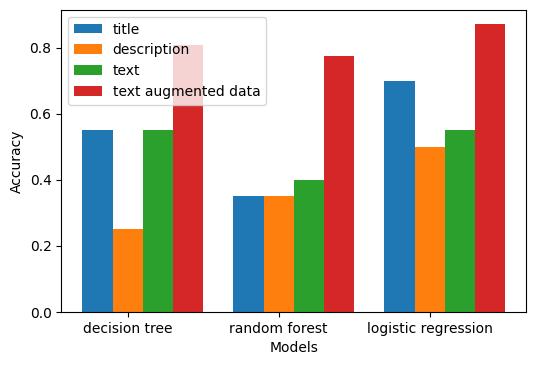

In [77]:
# accuracy
y1 = [accuracyTtl_dt, accuracyTtl_rf, accuracyTtl_lr]
y2 = [accuracyDscp_dt, accuracyDscp_rf, accuracyDscp_lr]
y3 = [accuracyTxt_dt, accuracyTxt_rf, accuracyTxt_lr]
y4 = [accuracyaug_dt, accuracyaug_rf, accuracyaug_lr]

plotBarGraph(y1, y2, y3, y4, "Accuracy")

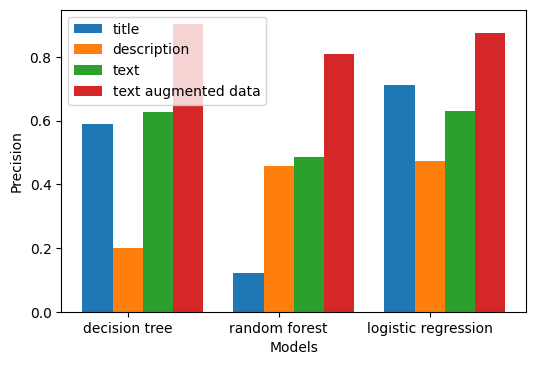

In [79]:
# Precision
y1 = [precisionTtl_dt, precisionTtl_rf, precisionTtl_lr]
y2 = [precisionDscp_dt, precisionDscp_rf, precisionDscp_lr]
y3 = [precisionTxt, precisionTxt_rf, precisionTxt_lr]
y4 = [precisionaug_dt, precisionaug_rf, precisionaug_lr]

plotBarGraph(y1, y2, y3, y4, "Precision")

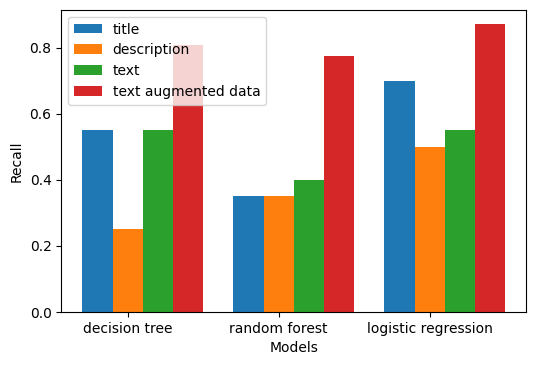

In [80]:
# Precision
y1 = [recallTtl_dt, recallTtl_rf, recallTtl_lr]
y2 = [recallDscp_dt, recallDscp_rf, recallDscp_lr]
y3 = [recallTxt_dt, recallTxt_rf, recallTxt_lr]
y4 = [recallaug_dt, recallaug_rf, recallaug_lr]

plotBarGraph(y1, y2, y3, y4, "Recall")

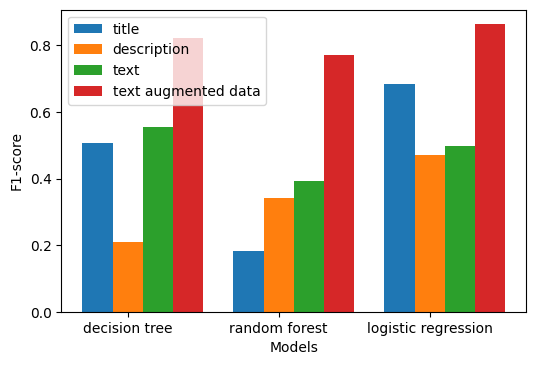

In [81]:
# F1-score
y1 = [0.506, 0.181, 0.683]
y2 = [0.209, 0.342, 0.471]
y3 = [0.555, 0.393, 0.499]
y4 = [0.821, 0.772, 0.864]

plotBarGraph(y1, y2, y3, y4, "F1-score")

## HyperParameter tuning using Cross validation

From the above model evaluations, the logistic regression classifier achieves the maximum accuracy and f1-score. Hence, this model will be further tuned to verify if an improvement is possible. 

Also, it can be observed that all the models showed a significant improvement in performance when trained with the augmented dataset. Hence, the augmented dataset will be used.

In [32]:
def crossValidation(train, test):
    """
    This function builds the cross validation model which choses the best parameter among the given grid
    and returns the metrics for a given test set.
    """
    # Build the evaluator for the cross validator to focus on. For this use case, the accuracy is considered
    evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    
    # Create initial logistic regression Model
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
    
    # Build the param grid.
    paramGrid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
                 .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
                 .addGrid(lr.maxIter, [10, 20, 50]) # Number of iterations
                 .build())
    
    # Building the cross validator
    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4, 
                              parallelism=2)
    
    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)

    # Make predictions on test documents. cvModel uses the best model found.
    prediction = cvModel.transform(test)
    
    return metricsEvaluation(prediction), cvModel

#### Original LR model metrics
Accuracy = 0.870968
Precision = 0.874194
Recall = 0.870968
F1_score = 0.864823

In [36]:
accuracyaug_cv, precisionaug_cv, recallaug_cv, confusionMatrixaug_cv, cvModel = crossValidation(aug_train, aug_test)

Accuracy = 0.83871
Precision = 0.890323
Recall = 0.83871
F1_score = 0.829032

CONFUSION MATRIX

[[ 3  1  3  0]
 [ 0  5  1  0]
 [ 0  0  6  0]
 [ 0  0  0 12]]


## Generate Predictions (seniority level) for the actual test set 

In [16]:
# generate embeddings
document_assembler = DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

# convert document to array of tokens
tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")

#check spellings
spell_model = ContextSpellCheckerModel\
        .pretrained('spellcheck_dl')\
        .setInputCols("token")\
        .setOutputCol("corrected")

# clean tokens 
normalizer = Normalizer() \
        .setInputCols(["corrected"]) \
        .setOutputCol("normalized")

# remove stopwords
stopwords_cleaner = StopWordsCleaner()\
          .setInputCols("normalized")\
          .setOutputCol("cleanTokens")\
          .setCaseSensitive(False)

# lemmas tokens to bring it to root form
lemmatizer = LemmatizerModel.pretrained() \
        .setInputCols(["token"]) \
        .setOutputCol("lemma")

# Convert custom document structure to array of tokens.
finisher = Finisher() \
        .setInputCols(["lemma"]) \
        .setOutputCols(["token_features"]) \
        .setOutputAsArray(True) \
        .setCleanAnnotations(False)

# To generate Term Frequency
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=1000)

# To generate Inverse Document Frequency
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

# define the nlp pipeline
nlp_pipeline = Pipeline(
        stages=[document_assembler, 
                tokenizer,
                spell_model,
                normalizer,
                stopwords_cleaner, 
                lemmatizer, 
                finisher,
                hashingTF,
                idf])
# fit the pipeline
pipeline_model = nlp_pipeline.fit(sparkTestDf)
    
# generate embeddings
test_embeddings =  pipeline_model.transform(sparkTestDf)

spellcheck_dl download started this may take some time.
Approximate size to download 111.4 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [17]:
# Create logistic regression Model since that is the best model achieved so far
model = LogisticRegression(featuresCol = 'features', labelCol = 'label')
    
# Fit the model on the augmented dataset
lr = model.fit(augEmbeddings)

#generate predictions
classification = lr.transform(test_embeddings)

In [18]:
# mapping the predictions to the levels
map_levels = {0.0: "Senior-level", 1.0: "Mid-level", 2.0: "Entry-level", 3.0: "Internship"}

classification_df = classification.select("title", "description", "prediction").toPandas()

classification_df["level"] = classification_df["prediction"].apply(lambda x: map_levels[x])

#display the head.
display(classification_df.head())

#save the datframe as csv file
classification_df.to_csv("../Data/Prediction_updated.csv")

,title,description,prediction,level
0,customer service netherlands in berlin,outfitter is europe biggest personal shopping ...,2.0,Entry-level
1,devo ps engineer,outfitter is europe biggest personal shopping ...,0.0,Senior-level
2,head of product management it,outfitter is europe biggest personal shopping ...,0.0,Senior-level
3,help desk support,outfitter is europe biggest personal shopping ...,0.0,Senior-level
4,intern help desk,outfitter is europe biggest personal shopping ...,3.0,Internship


In [ ]:
#spark.stop()